In [ ]:
import numpy as np 
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F

from PIL import Image
import cv2
import albumentations as A


from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp


     |████████████████████████████████| 102 kB 10.5 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
     |████████████████████████████████| 376 kB 51.6 MB/s 


In [ ]:
#load google doc
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Preprocessing

In [ ]:
#load data from google doc
IMAGE_PATH = '/content/drive/MyDrive/Deep Learning Project/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/drive/MyDrive/Deep Learning Project/dataset/semantic_drone_dataset/label_images_semantic/'

In [ ]:
NumOfClasses = 23 

#split and store image data
def Create_dataset():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

data = Create_dataset()
print('Total Images: ', len(data))

Total Images:  400


##data distribution

In [ ]:
label_path='/content/drive/MyDrive/Deep Learning Project/dataset/semantic_drone_dataset/label_colors/'


In [ ]:
#split and store the masks
def create_cp():
    name = []
    for dirname, _, filenames in os.walk(label_path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'type': name}, index = np.arange(0, len(name)))

cp = create_cp()

In [ ]:
from collections import Counter
from sklearn.cluster import KMeans
from matplotlib import colors


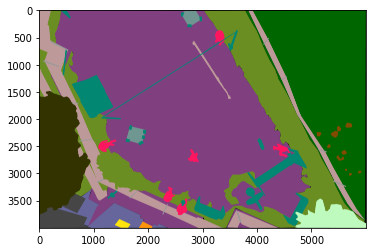

In [ ]:
image_try = cv2.imread('/content/drive/MyDrive/Deep Learning Project/RGB_color_image_masks/001.png')
image_try = cv2.cvtColor(image_try, cv2.COLOR_BGR2RGB)
plt.imshow(image_try)

In [ ]:
#rgb format to hex format
def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        i = int(i)
        hex_color += ("{:02x}".format(i))
    return hex_color

In [ ]:
#resize the image to a smaller size to let it faster to process, reshape it to let data be able to get into analysis model
def prep_image(raw_img):
    modified_img = cv2.resize(raw_img, (900, 600), interpolation = cv2.INTER_AREA)
    modified_img = modified_img.reshape(modified_img.shape[0]*modified_img.shape[1], 3)
    return modified_img

In [ ]:
#model to analysis the colors distribution in the mask
def color_analysis(img):
    #cluster the top colors
    clf = KMeans(n_clusters = 8)
    color_labels = clf.fit_predict(img)
    center_colors = clf.cluster_centers_
    #counter funtion to count the volumn of different colors to store in dictionary
    counts = Counter(color_labels)
    ordered_colors = [center_colors[i] for i in counts.keys()]
    #convert to hex value
    hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()]
    #visualize the Output
    plt.figure(figsize = (12, 8))
    plt.pie(counts.values(),  colors = hex_colors)
    plt.title("Color distribution in a musk")
    print(hex_colors)

['#b69897', '#7e4180', '#048672', '#35350c', '#6c8d23', '#006500', '#fb1760', '#bdf9bd']


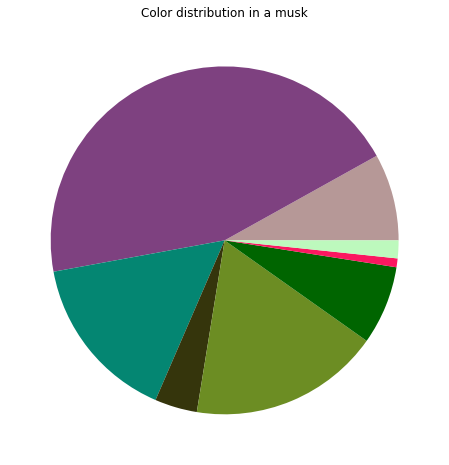

In [ ]:
modified_image = prep_image(image_try)
color_analysis(modified_image)

In [ ]:
#split data into test and train
X_trainval, X_test = train_test_split(data['id'].values, test_size=0.1, random_state=20)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=20)

Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


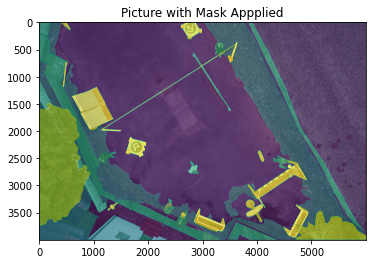

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][1] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][1] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)



plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

Text(0.5, 1.0, 'mask')

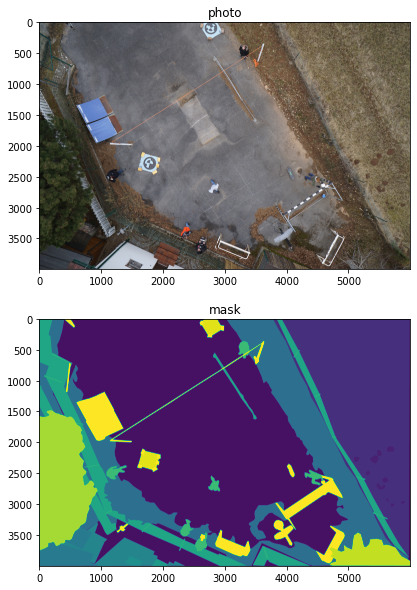

In [ ]:
fig, (pic1, pic2) = plt.subplots(2,1, figsize=(20,10))
pic1.imshow(img)
pic1.set_title('photo')
pic2.imshow(mask)
pic2.set_title('mask')

##Dataset

In [ ]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        #convert array to tensor
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):
        #store data after scanning convolution kernel
        patch_img = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        patch_img  = patch_img.contiguous().view(3,-1, 512, 768) 
        patch_img = patch_img.permute(1,0,2,3)
        
        patch_mask = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        patch_mask = patch_mask.contiguous().view(-1, 512, 768)
        
        return patch_img, patch_mask

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

#tune the image/ Preprocessing
t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

#Model

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

#Training

In [ ]:
def pixel_accuracy(result, mask):
    with torch.no_grad():
        result = torch.argmax(F.softmax(result, dim=1), dim=1)
        correct = torch.eq(result, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
#mIoU calculation
def mIoU(mask_pred, mask, smooth=1e-10, NumOfClasses=23):
    with torch.no_grad():
        mask_pred = F.softmax(mask_pred, dim=1)
        mask_pred = torch.argmax(mask_pred, dim=1)
        mask_pred = mask_pred.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, NumOfClasses): #loop per pixel class
            real_class = mask_pred == clas
            real_label = mask == clas

            if real_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(real_class, real_label).sum().float().item()
                union = torch.logical_or(real_class, real_label).sum().float().item()
                #iou = tp/(tp+tn+fn)
                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
#set train process & return scores
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_los = []
    test_los = []
    val_IoU = []; val_acc = []
    train_IoU = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_los = 0
        score_IoU = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            img_tile, mask_tile = data
            if patch:
                bs, n_tiles, c, h, w = img_tile.size()

                img_tile = img_tile.view(-1,c, h, w)
                mask_tile = mask_tile.view(-1, h, w)
            
            image = img_tile.to(device); mask = mask_tile.to(device);
            #forward
            result = model(image)
            loss = criterion(result, mask)
            #evaluation metrics
            score_IoU += mIoU(result, mask)
            accuracy += pixel_accuracy(result, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_los += loss.item()
            
        else:
            model.eval()
            los_test = 0
            test_accuracy = 0
            val_IoU_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    img_tile, mask_tile = data

                    if patch:
                        bs, n_tiles, c, h, w = img_tile.size()

                        img_tile = img_tile.view(-1,c, h, w)
                        mask_tile = mask_tile.view(-1, h, w)
                    
                    image = img_tile.to(device); mask = mask_tile.to(device);
                    result = model(image)
                    #evaluation metrics
                    val_IoU_score +=  mIoU(result, mask)
                    test_accuracy += pixel_accuracy(result, mask)
                    #loss
                    loss = criterion(result, mask)                                  
                    los_test += loss.item()
            
            #calculatio mean for each batch
            train_los.append(running_los/len(train_loader))
            test_los.append(los_test/len(val_loader))


            if min_loss > (los_test/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (los_test/len(val_loader))))
                min_loss = (los_test/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_IoU_score/len(val_loader)))
                    

            if (los_test/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (los_test/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_IoU.append(val_IoU_score/len(val_loader))
            train_IoU.append(score_IoU/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_los/len(train_loader)),
                  "Val Loss: {:.3f}..".format(los_test/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(score_IoU/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_IoU_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_los, 'val_loss': test_los,
               'train_miou' :train_IoU, 'val_miou':val_IoU,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#set hype-parameter
max_lr = 1e-3
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
#train model
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.961 
Epoch:1/20.. Train Loss: 2.809.. Val Loss: 1.961.. Train mIoU:0.052.. Val mIoU: 0.106.. Train Acc:0.267.. Val Acc:0.574.. Time: 18.25m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.961 >> 1.371 
Epoch:2/20.. Train Loss: 1.937.. Val Loss: 1.371.. Train mIoU:0.121.. Val mIoU: 0.151.. Train Acc:0.579.. Val Acc:0.673.. Time: 4.53m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.371 >> 1.308 
Epoch:3/20.. Train Loss: 1.482.. Val Loss: 1.308.. Train mIoU:0.143.. Val mIoU: 0.149.. Train Acc:0.625.. Val Acc:0.651.. Time: 4.52m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.308 >> 1.146 
saving model...
Epoch:4/20.. Train Loss: 1.320.. Val Loss: 1.146.. Train mIoU:0.150.. Val mIoU: 0.145.. Train Acc:0.647.. Val Acc:0.643.. Time: 4.49m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/20.. Train Loss: 1.239.. Val Loss: 1.165.. Train mIoU:0.156.. Val mIoU: 0.149.. Train Acc:0.649.. Val Acc:0.649.. Time: 4.47m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.165 >> 0.981 
Epoch:6/20.. Train Loss: 1.193.. Val Loss: 0.981.. Train mIoU:0.163.. Val mIoU: 0.180.. Train Acc:0.656.. Val Acc:0.722.. Time: 4.49m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:7/20.. Train Loss: 1.161.. Val Loss: 1.013.. Train mIoU:0.174.. Val mIoU: 0.185.. Train Acc:0.659.. Val Acc:0.711.. Time: 4.48m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.013 >> 0.877 
Epoch:8/20.. Train Loss: 1.040.. Val Loss: 0.877.. Train mIoU:0.188.. Val mIoU: 0.228.. Train Acc:0.697.. Val Acc:0.752.. Time: 4.45m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.877 >> 0.804 
Epoch:9/20.. Train Loss: 0.979.. Val Loss: 0.804.. Train mIoU:0.209.. Val mIoU: 0.238.. Train Acc:0.715.. Val Acc:0.758.. Time: 4.51m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.804 >> 0.720 
Epoch:10/20.. Train Loss: 0.924.. Val Loss: 0.720.. Train mIoU:0.226.. Val mIoU: 0.249.. Train Acc:0.730.. Val Acc:0.784.. Time: 4.52m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/20.. Train Loss: 0.854.. Val Loss: 0.793.. Train mIoU:0.241.. Val mIoU: 0.244.. Train Acc:0.748.. Val Acc:0.765.. Time: 4.50m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.793 >> 0.655 
saving model...
Epoch:12/20.. Train Loss: 0.841.. Val Loss: 0.655.. Train mIoU:0.251.. Val mIoU: 0.275.. Train Acc:0.753.. Val Acc:0.796.. Time: 4.49m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.655 >> 0.630 
Epoch:13/20.. Train Loss: 0.841.. Val Loss: 0.630.. Train mIoU:0.260.. Val mIoU: 0.302.. Train Acc:0.753.. Val Acc:0.811.. Time: 4.45m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.630 >> 0.588 
Epoch:14/20.. Train Loss: 0.727.. Val Loss: 0.588.. Train mIoU:0.279.. Val mIoU: 0.316.. Train Acc:0.784.. Val Acc:0.821.. Time: 4.47m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.588 >> 0.566 
Epoch:15/20.. Train Loss: 0.667.. Val Loss: 0.566.. Train mIoU:0.299.. Val mIoU: 0.312.. Train Acc:0.801.. Val Acc:0.827.. Time: 4.48m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.566 >> 0.540 
Epoch:16/20.. Train Loss: 0.628.. Val Loss: 0.540.. Train mIoU:0.311.. Val mIoU: 0.320.. Train Acc:0.814.. Val Acc:0.832.. Time: 4.45m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.540 >> 0.510 
saving model...
Epoch:17/20.. Train Loss: 0.610.. Val Loss: 0.510.. Train mIoU:0.326.. Val mIoU: 0.342.. Train Acc:0.819.. Val Acc:0.842.. Time: 4.49m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.510 >> 0.510 
Epoch:18/20.. Train Loss: 0.590.. Val Loss: 0.510.. Train mIoU:0.321.. Val mIoU: 0.352.. Train Acc:0.823.. Val Acc:0.846.. Time: 4.42m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.510 >> 0.509 
Epoch:19/20.. Train Loss: 0.567.. Val Loss: 0.509.. Train mIoU:0.340.. Val mIoU: 0.345.. Train Acc:0.834.. Val Acc:0.844.. Time: 4.44m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.509 >> 0.508 
Epoch:20/20.. Train Loss: 0.559.. Val Loss: 0.508.. Train mIoU:0.339.. Val mIoU: 0.351.. Train Acc:0.834.. Val Acc:0.847.. Time: 4.47m
Total time: 103.35 m


In [ ]:
torch.save(model, 'Unet-Mobilenet.pt')

In [ ]:
#plot train and validation accuracy
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

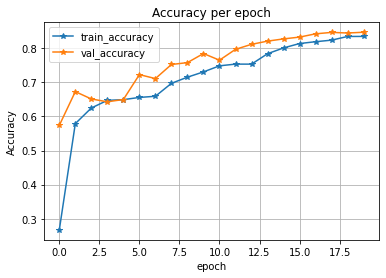

In [ ]:
plot_acc(history)

#Evaluation

In [ ]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    #read original picture and ground truth mask
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
#feed in images and return mask and iou scores
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        result = model(image)
        score = mIoU(result, mask)
        masked = torch.argmax(result, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
image, mask = test_set[4]
mask_pred, score = predict_image_mask_miou(model, image, mask)

Text(0.5, 1.0, 'Output with mIoU score: 0.314')

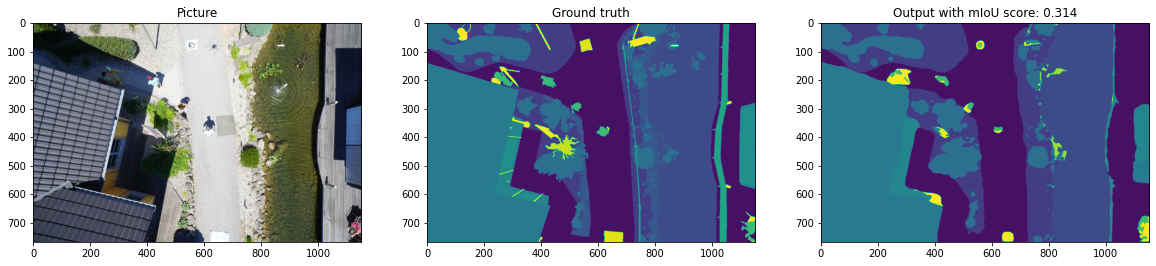

In [ ]:
#dataset Output1
fig, (pic1, pic2, pic3) = plt.subplots(1,3, figsize=(20,10))
pic1.imshow(image)
pic1.set_title('Picture');

pic2.imshow(mask)
pic2.set_title('Ground truth')

pic3.imshow(mask_pred)
pic3.set_title('Output with mIoU score: {:.3f}'.format(score))

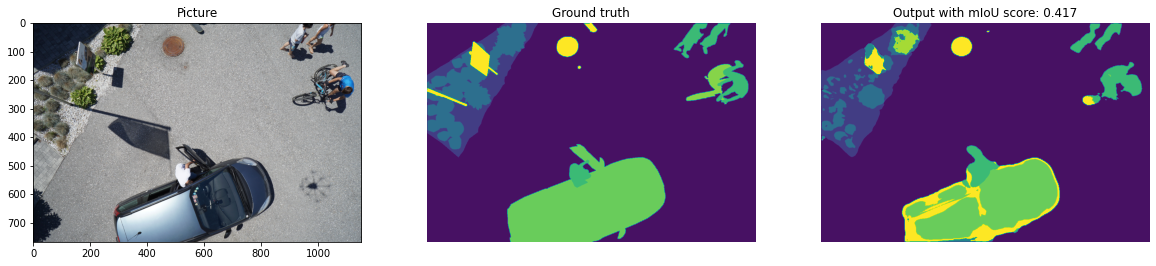

In [ ]:
#dataset Output2
image2, mask2 = test_set[5]
mask_pred2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (pic1, pic2, pic3) = plt.subplots(1,3, figsize=(20,10))
pic1.imshow(image2)
pic1.set_title('Picture');

pic2.imshow(mask2)
pic2.set_title('Ground truth')
pic2.set_axis_off()

pic3.imshow(mask_pred2)
pic3.set_title('Output with mIoU score: {:.3f}'.format(score2))
pic3.set_axis_off()

Text(0.5, 1.0, 'Output with mIoU score: 0.212')

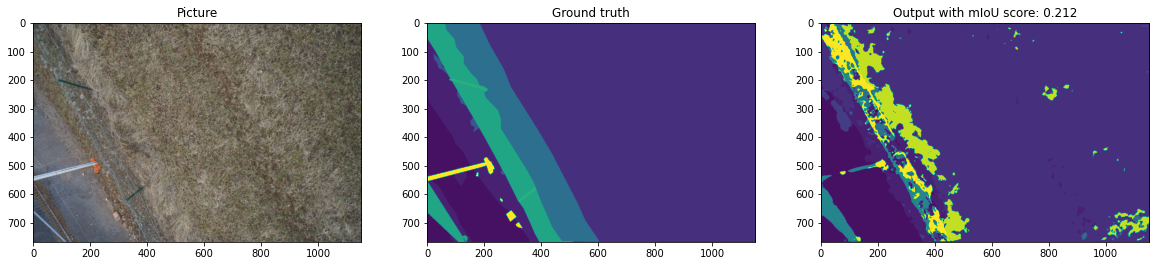

In [ ]:
#dataset Output3
image3, mask3 = test_set[7]
mask_pred3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (pic1, pic2, pic3) = plt.subplots(1,3, figsize=(20,10))
pic1.imshow(image3)
pic1.set_title('Picture');

pic2.imshow(mask3)
pic2.set_title('Ground truth')

pic3.imshow(mask_pred3)
pic3.set_title('Output with mIoU score: {:.3f}'.format(score3))

#Google map image prediction

In [ ]:
def predict_image(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        
        
        result = model(image)
        masked = torch.argmax(result, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

Text(0.5, 1.0, 'original_image')

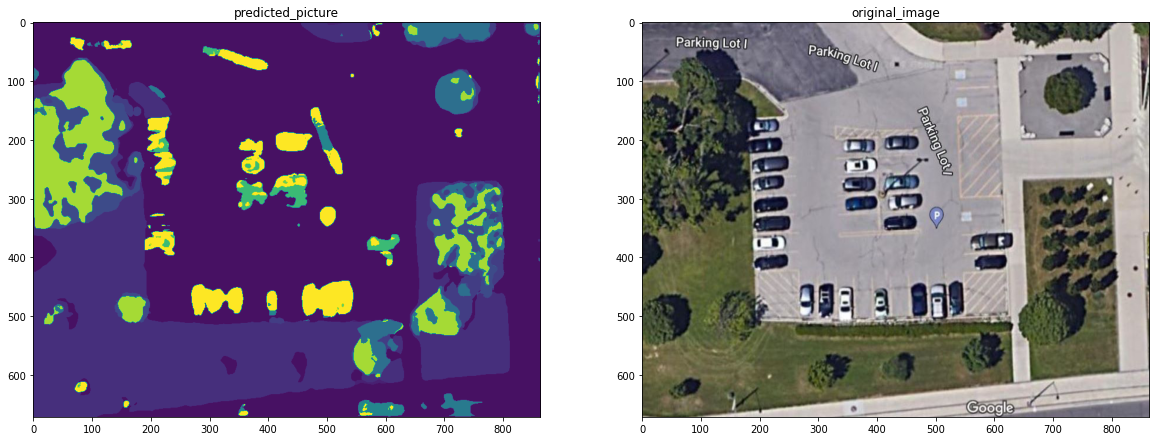

In [ ]:
image_map= Image.open('/content/drive/MyDrive/Deep Learning Project/dataset/semantic_drone_dataset/predict_image1.jpg')
fig, (pic1, pic2) = plt.subplots(1,2, figsize=(20,10))
mask_pred_map = predict_image(model, image_map)
pic1.imshow(mask_pred_map)
pic1.set_title('predicted_picture');
pic2.imshow(image_map)
pic2.set_title('original_image')

Text(0.5, 1.0, 'original_image')

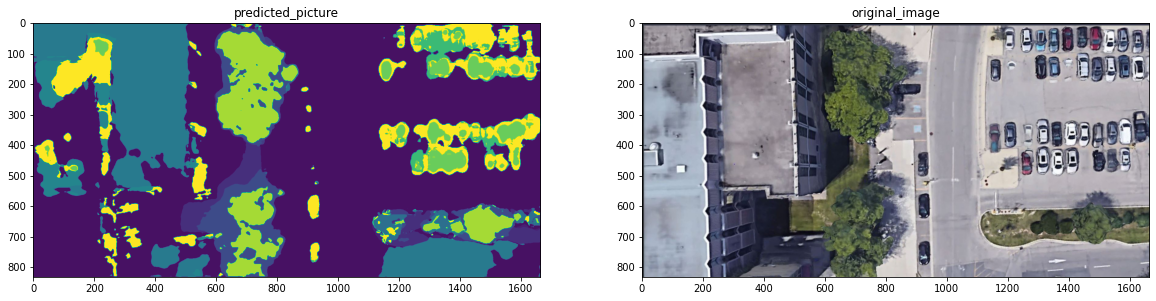

In [ ]:
image_map2= Image.open('/content/drive/MyDrive/Deep Learning Project/dataset/semantic_drone_dataset/predict_image2.JPG')
fig, (pic1, pic2) = plt.subplots(1,2, figsize=(20,10))
mask_pred_map2 = predict_image(model, image_map2)
pic1.imshow(mask_pred_map2)
pic1.set_title('predicted_picture');
pic2.imshow(image_map2)
pic2.set_title('original_image')